# Stochastic Gradient Descent by Epoch

One of the fundamental assumptions of Stochastic Gradient Descent (SGD) is that points from the input data (X) are selected independently and randomly. However, this random selection process can be computationally expensive and may also lead to cache misses when working with very large datasets. A solution inspired by Meng et al. (2019) is to shuffle the input data independently at the start, and then iterate through the shuffled data. While shuffling large datasets is itself computationally expensive, this approach significantly improves performance by eliminating the need to randomly select each point during training. However, this procedure deviates from the basic assumption of random sampling, as once a point is selected in an epoch, it cannot be selected again—effectively resulting in sampling without replacement. Nevertheless, we found that this method still achieved convergence in much quicker times.

**Importing Libraries**

In [1]:
from SGD_by_Epoch import shuffle_data, sgd_by_epoch_process
from multiprocessing import Pool
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(42)

#### Methodology
The SGD by epoch approach implements the following steps:
1. **Data Pre-processing**: The input feature X and target variable y were normalized to ensure consistent scaling, which improves the stability and efficiency of model training.
2. **Polynomial Basis Function Transformation**: The input feature X was transformed into polynomial features of degree h−1, enabling the model to fit higher-order relationships in the data.
3. **Independent Shuffling of Input Features**: To improve computational efficiency, the data was shuffled independently across t processors at the start of training. Each processor received its own shuffled version of the data, allowing parallel computation without the need for additional shuffling during iterations.
4. **Random Initialization of Weights**: The model weights β were randomly initialized and shared across all processors as the starting point for training.
5. **Processor-specific Epoch Iterations**: Each processor independently iterated through its version of the shuffled data in sequence, for one epoch, updating the weights.
6. **Averaging Results**: After completing each epoch, the t processors returned their estimates of β. These estimates were averaged to obtain a unified global estimate, which was then shared among all processors for the next epoch.
7. **Iterative Updates Across Epochs**: Steps 5 and 6 were repeated for n epochs. The model refined its weights incrementally with each iteration.
8. **Dynamic Learning Rate**: A dynamic learning rate mechanism was introduced to improve stability and convergence during training. The learning rate decreases with the epoch to prevent overshooting during convergence.
Final Weight Extraction: At the conclusion of training, the final β values represented the optimized weights of the model.

**Importing Data**

In [2]:
dataframe = pd.read_excel('dataset1/dataset1.xlsx')

X = dataframe['V'].sort_values()
X = (X-X.mean()) / X.std()
y = dataframe['AT'][X.index].values
y = (y-y.mean()) / y.std()

X = np.reshape(X.values, (-1,1))

**Defining Useful Functions**

In [3]:
def polynomial_basis_function_transformation(X, h):
    """
    Converts an (N * 1) matrix into a (N * h) matrix, where h is the number of basis functions.
    The degree of the polynomial is (h-1).

    Parameters:
    - X: (N * 1) matrix of input features.
    - h: Number of basis functions (degree + 1).

    Returns:
    - X_poly: (N * h) matrix after applying polynomial basis functions.
    """
    powers = np.arange(h)
    X_poly = np.power(X, powers)
    return X_poly

In [4]:
def sgd_by_epoch(X, y, h, alpha, n, t):
    """
    Conducts Linear Regression using SGD with parallelization by epoch.
    """
    start = datetime.now()
    X_poly = polynomial_basis_function_transformation(X, h)
    epoch_size = len(X_poly)
    full_epochs = n // epoch_size

    # Initialize shared weights for the first epoch
    shared_weights = np.random.rand(h)

    # Parallelize shuffling
    with Pool(processes=t) as pool:
        shuffled_data = pool.starmap(shuffle_data, [(X_poly, y) for _ in range(t)])

    mse_history = []  # Track MSE for each epoch

    for epoch in range(full_epochs):
        epoch_start = datetime.now()

        with Pool(processes=t) as pool:
            outputs = pool.starmap(
                sgd_by_epoch_process,
                [(shuffled_data[i][0], shuffled_data[i][1], h, alpha, shared_weights) for i in range(t)]
            )

        shared_weights = np.mean(outputs, axis=0)

        # Calculate MSE for the current epoch
        y_hat_poly = X_poly @ shared_weights
        mse = mean_squared_error(y, y_hat_poly)
        mse_history.append(mse)

        epoch_end = datetime.now()

        print(f"Epoch {epoch + 1}/{full_epochs}, MSE: {mse}, Time for Epoch: {epoch_end - epoch_start}")

    final_beta_hat = shared_weights
    total_end = datetime.now()
    print(f"Total Time for Training: {total_end - start}")

    return mse_history

def plot_mse_vs_epochs(X, y, h, alpha, n):
    t_values = [1, 2, 3, 4, 8]  # List of `t` values
    plt.figure(figsize=(10, 6))

    for t in t_values:
        mse_history = sgd_by_epoch(X, y, h, alpha, n, t)
        plt.plot(range(1, len(mse_history) + 1), mse_history, label=f't={t}')

    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs Epochs for Different Number of Processes')
    
    # Set log scale for MSE (y-axis)
    plt.yscale('log')

    # Adding grid and legend
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(1, len(mse_history) + 1, 1))  # Ensure x-axis is integer and includes all epochs
    plt.show()

Epoch 1/20, MSE: 0.27782004038006913, Time for Epoch: 0:00:00.553061
Epoch 2/20, MSE: 0.2750167906076482, Time for Epoch: 0:00:00.622630
Epoch 3/20, MSE: 0.2748873114055222, Time for Epoch: 0:00:00.573995
Epoch 4/20, MSE: 0.27485711118812345, Time for Epoch: 0:00:00.585838
Epoch 5/20, MSE: 0.2748484957850052, Time for Epoch: 0:00:00.600168
Epoch 6/20, MSE: 0.2748461449977717, Time for Epoch: 0:00:00.574200
Epoch 7/20, MSE: 0.27484552366231857, Time for Epoch: 0:00:00.602839
Epoch 8/20, MSE: 0.2748453620409041, Time for Epoch: 0:00:00.640334
Epoch 9/20, MSE: 0.2748453203143003, Time for Epoch: 0:00:00.574497
Epoch 10/20, MSE: 0.274845309578396, Time for Epoch: 0:00:00.637309
Epoch 11/20, MSE: 0.2748453068203946, Time for Epoch: 0:00:00.668030
Epoch 12/20, MSE: 0.2748453061123646, Time for Epoch: 0:00:00.587727
Epoch 13/20, MSE: 0.2748453059306556, Time for Epoch: 0:00:00.619920
Epoch 14/20, MSE: 0.274845305884028, Time for Epoch: 0:00:00.612633
Epoch 15/20, MSE: 0.27484530587206385, Tim

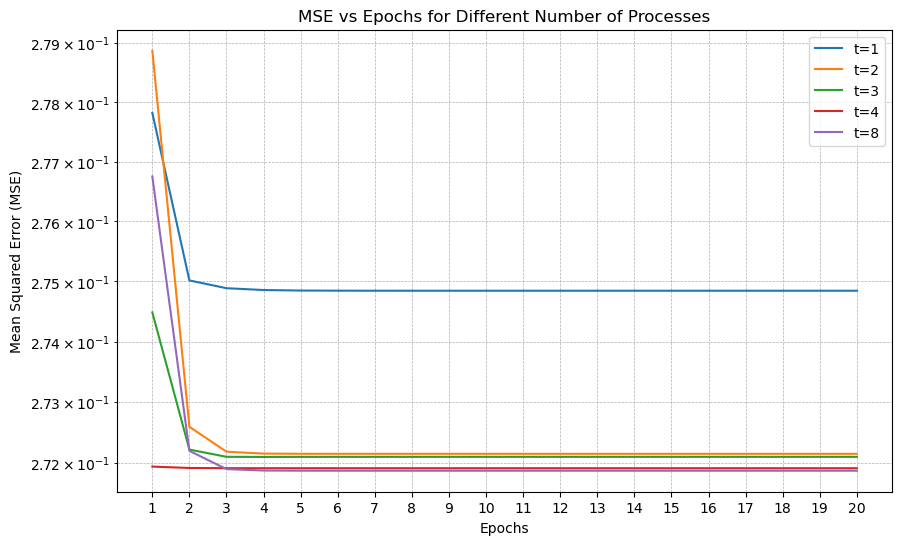

In [31]:
# Plot for learning rate of 0.001
plot_mse_vs_epochs(X, y, 4, 0.001, 200000)

Epoch 1/20, MSE: 0.3936314393629052, Time for Epoch: 0:00:00.546028
Epoch 2/20, MSE: 0.35470202353967784, Time for Epoch: 0:00:00.555707
Epoch 3/20, MSE: 0.33232289549683297, Time for Epoch: 0:00:00.607512
Epoch 4/20, MSE: 0.3162532960290843, Time for Epoch: 0:00:00.580586
Epoch 5/20, MSE: 0.30460318775425504, Time for Epoch: 0:00:00.534290
Epoch 6/20, MSE: 0.29611180505427254, Time for Epoch: 0:00:00.550441
Epoch 7/20, MSE: 0.2898905181248913, Time for Epoch: 0:00:00.540128
Epoch 8/20, MSE: 0.2853103762626711, Time for Epoch: 0:00:00.536947
Epoch 9/20, MSE: 0.2819235680570695, Time for Epoch: 0:00:00.550685
Epoch 10/20, MSE: 0.27940920017613097, Time for Epoch: 0:00:00.534335
Epoch 11/20, MSE: 0.27753587706545874, Time for Epoch: 0:00:00.541033
Epoch 12/20, MSE: 0.27613573931850555, Time for Epoch: 0:00:00.551672
Epoch 13/20, MSE: 0.27508633377581027, Time for Epoch: 0:00:00.536144
Epoch 14/20, MSE: 0.27429786612106066, Time for Epoch: 0:00:00.549657
Epoch 15/20, MSE: 0.27370417647446

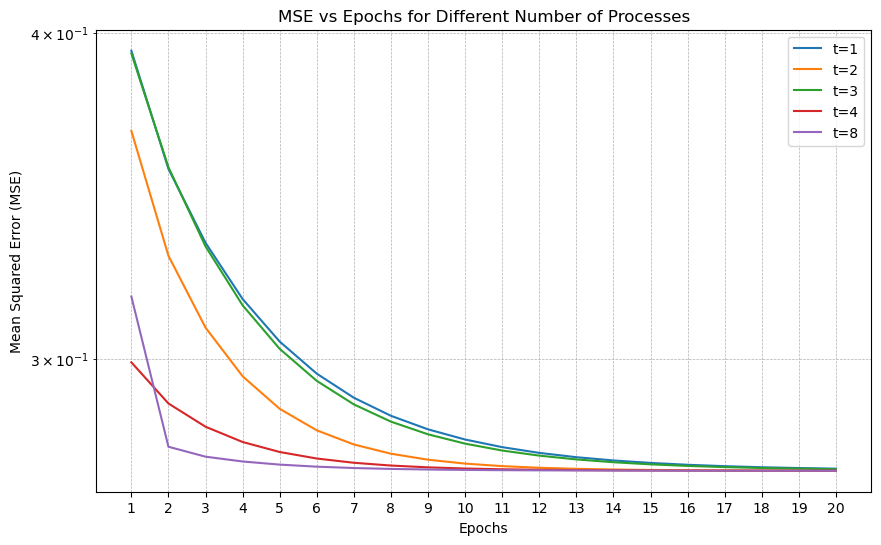

In [28]:
# Plot for learning rate of 0.0001
plot_mse_vs_epochs(X, y, 4, 0.0001, 200000)

##### A dynamic learning rate was added to improve convergence during training. Starting with a larger learning rate helped the model learn quickly in the early stages, while gradually reducing it over epochs ensured more stable and precise convergence, preventing overshooting. This adjustment made the model more accurate and consistent as training progressed.

In [4]:
def sgd_by_epoch(X, y, h, b_alpha, n, t):
    """
    Conducts Linear Regression using SGD with parallelization by epoch.
    """
    start = datetime.now()
    X_poly = polynomial_basis_function_transformation(X, h)
    epoch_size = len(X_poly)
    full_epochs = n // epoch_size

    shared_weights = np.random.rand(h)

    with Pool(processes=t) as pool:
        shuffled_data = pool.starmap(shuffle_data, [(X_poly, y) for _ in range(t)])

    mse_history = []  # Track MSE for each epoch
    
    """
    To improve the stability and convergence of the training process, 
    implemented a dynamic learning rate mechanism. 
    This adjustment allowed the learning rate to adapt progressively during training, 
    ensuring continuous convergence of the epochs.
    """
    for epoch in range(full_epochs):
        alpha = dynamic_learning_rate(epoch, b_alpha)
        epoch_start = datetime.now()

        with Pool(processes=t) as pool:
            outputs = pool.starmap(
                sgd_by_epoch_process,
                [(shuffled_data[i][0], shuffled_data[i][1], h, alpha, shared_weights) for i in range(t)]
            )

        shared_weights = np.mean(outputs, axis=0)

        y_hat_poly = X_poly @ shared_weights
        mse = mean_squared_error(y, y_hat_poly)
        mse_history.append(mse)

        epoch_end = datetime.now()

        print(f"Epoch {epoch + 1}/{full_epochs}, MSE: {mse}, Time for Epoch: {epoch_end - epoch_start}")

    final_beta_hat = shared_weights
    total_end = datetime.now()
    print(f"Total Time for Training: {total_end - start}")

    return mse_history

# Adding function for dynamic learning rate
def dynamic_learning_rate(epoch, base_alpha, decay_rate=0.1):
    return base_alpha / (1 + decay_rate * epoch)

# Plotting Function with Debugging
def plot_mse_vs_epochs(X, y, h, alpha, n):
    t_values = [1, 2, 3, 4, 8]  # List of `t` values
    plt.figure(figsize=(10, 6))

    for t in t_values:
        print(f"Starting SGD with t={t}")
        mse_history = sgd_by_epoch(X, y, h, alpha, n, t)
        print(f"MSE history for t={t}: {mse_history}")  # Debug statement
        if mse_history:  # Ensure there's data to plot
            plt.plot(range(1, len(mse_history) + 1), mse_history, label=f't={t}')
        else:
            print(f"No data to plot for t={t}")

    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs Epochs for Different Number of Processes')

    # Set log scale for MSE (y-axis)
    plt.yscale('log')

    # Adding grid and legend
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(1, len(mse_history) + 1, 1))  # Ensure x-axis is integer and includes all epochs
    plt.show()

Starting SGD with t=1
Epoch 1/20, MSE: 0.2799337449382405, Time for Epoch: 0:00:00.563023
Epoch 2/20, MSE: 0.2725360871530841, Time for Epoch: 0:00:00.591811
Epoch 3/20, MSE: 0.27222829929541836, Time for Epoch: 0:00:00.509841
Epoch 4/20, MSE: 0.2722456805827214, Time for Epoch: 0:00:00.549802
Epoch 5/20, MSE: 0.2722457211985968, Time for Epoch: 0:00:00.522179
Epoch 6/20, MSE: 0.2722318838072096, Time for Epoch: 0:00:00.472833
Epoch 7/20, MSE: 0.27221400903461124, Time for Epoch: 0:00:00.525513
Epoch 8/20, MSE: 0.2721959074526732, Time for Epoch: 0:00:00.544224
Epoch 9/20, MSE: 0.2721787261908563, Time for Epoch: 0:00:00.511191
Epoch 10/20, MSE: 0.27216268929597476, Time for Epoch: 0:00:00.495886
Epoch 11/20, MSE: 0.27214773331195885, Time for Epoch: 0:00:00.526478
Epoch 12/20, MSE: 0.2721337241296046, Time for Epoch: 0:00:00.524331
Epoch 13/20, MSE: 0.2721205275331151, Time for Epoch: 0:00:00.553796
Epoch 14/20, MSE: 0.27210802926691074, Time for Epoch: 0:00:00.514575
Epoch 15/20, MSE

Epoch 12/20, MSE: 0.27183358974946786, Time for Epoch: 0:00:01.545184
Epoch 13/20, MSE: 0.27183169969263266, Time for Epoch: 0:00:01.378915
Epoch 14/20, MSE: 0.27183010865374724, Time for Epoch: 0:00:01.422631
Epoch 15/20, MSE: 0.2718287627656722, Time for Epoch: 0:00:01.426304
Epoch 16/20, MSE: 0.271827619077906, Time for Epoch: 0:00:01.400418
Epoch 17/20, MSE: 0.27182664309516474, Time for Epoch: 0:00:01.449501
Epoch 18/20, MSE: 0.2718258069223812, Time for Epoch: 0:00:01.466165
Epoch 19/20, MSE: 0.27182508785600007, Time for Epoch: 0:00:01.508984
Epoch 20/20, MSE: 0.27182446730587656, Time for Epoch: 0:00:01.564365
Total Time for Training: 0:00:30.880665
MSE history for t=8: [0.2737090391943137, 0.27193576479209564, 0.271885961594699, 0.271873450103101, 0.271864162993516, 0.27185671147906304, 0.27185069772850295, 0.2718458184061173, 0.2718418337833817, 0.2718385578279388, 0.27183584689678336, 0.27183358974946786, 0.27183169969263266, 0.27183010865374724, 0.2718287627656722, 0.271827

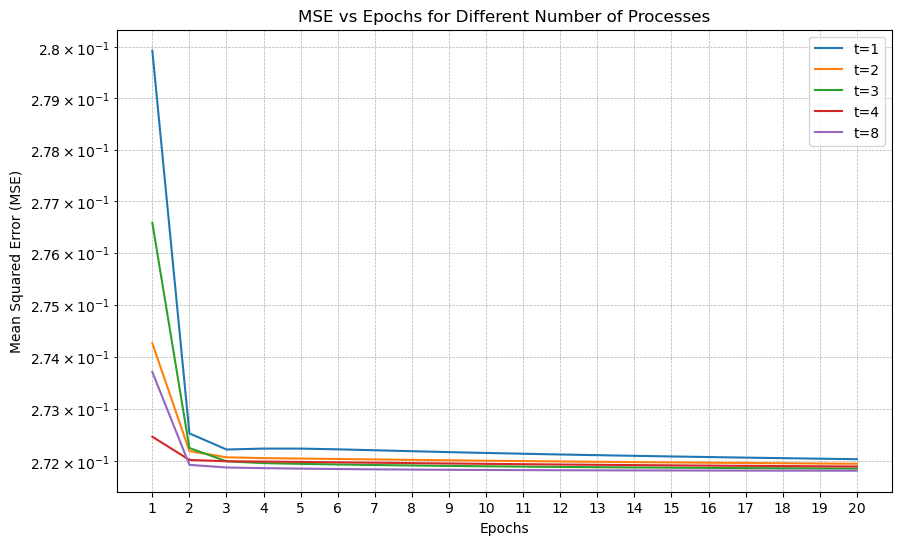

In [7]:
# Plot for base learning rate of 0.001 with dynamic learning rate
plot_mse_vs_epochs(X, y, 4, 0.001, 200000)

Starting SGD with t=1
Epoch 1/20, MSE: 0.4435339354708295, Time for Epoch: 0:00:00.537585
Epoch 2/20, MSE: 0.3685488142937323, Time for Epoch: 0:00:00.595230
Epoch 3/20, MSE: 0.34123296167584793, Time for Epoch: 0:00:00.588217
Epoch 4/20, MSE: 0.3235373745918772, Time for Epoch: 0:00:00.596639
Epoch 5/20, MSE: 0.31132048151923053, Time for Epoch: 0:00:00.551810
Epoch 6/20, MSE: 0.3026283846628958, Time for Epoch: 0:00:00.538461
Epoch 7/20, MSE: 0.2962897663881842, Time for Epoch: 0:00:00.560822
Epoch 8/20, MSE: 0.2915671579226161, Time for Epoch: 0:00:00.555590
Epoch 9/20, MSE: 0.2879813819389623, Time for Epoch: 0:00:00.580253
Epoch 10/20, MSE: 0.28521265184663475, Time for Epoch: 0:00:00.556887
Epoch 11/20, MSE: 0.28304245381517623, Time for Epoch: 0:00:00.558646
Epoch 12/20, MSE: 0.2813182910759972, Time for Epoch: 0:00:00.571779
Epoch 13/20, MSE: 0.2799316991761451, Time for Epoch: 0:00:00.543637
Epoch 14/20, MSE: 0.2788041953435887, Time for Epoch: 0:00:00.552475
Epoch 15/20, MSE:

Epoch 12/20, MSE: 0.2758291937647043, Time for Epoch: 0:00:01.401691
Epoch 13/20, MSE: 0.2753004337629916, Time for Epoch: 0:00:01.419620
Epoch 14/20, MSE: 0.27486294373562153, Time for Epoch: 0:00:01.446877
Epoch 15/20, MSE: 0.27449762404540323, Time for Epoch: 0:00:01.505904
Epoch 16/20, MSE: 0.2741900035229102, Time for Epoch: 0:00:01.567896
Epoch 17/20, MSE: 0.27392897899219504, Time for Epoch: 0:00:01.565814
Epoch 18/20, MSE: 0.273705932567392, Time for Epoch: 0:00:01.674199
Epoch 19/20, MSE: 0.2735141040106234, Time for Epoch: 0:00:01.483215
Epoch 20/20, MSE: 0.273348138143619, Time for Epoch: 0:00:01.587386
Total Time for Training: 0:00:31.915503
MSE history for t=8: [0.32772389058265744, 0.3038581122544082, 0.2955735378373482, 0.2900615712660393, 0.28614991849971533, 0.2832941176636468, 0.28115991369283955, 0.27953225040424473, 0.27826857602504745, 0.2772719203692836, 0.27647478188383107, 0.2758291937647043, 0.2753004337629916, 0.27486294373562153, 0.27449762404540323, 0.274190

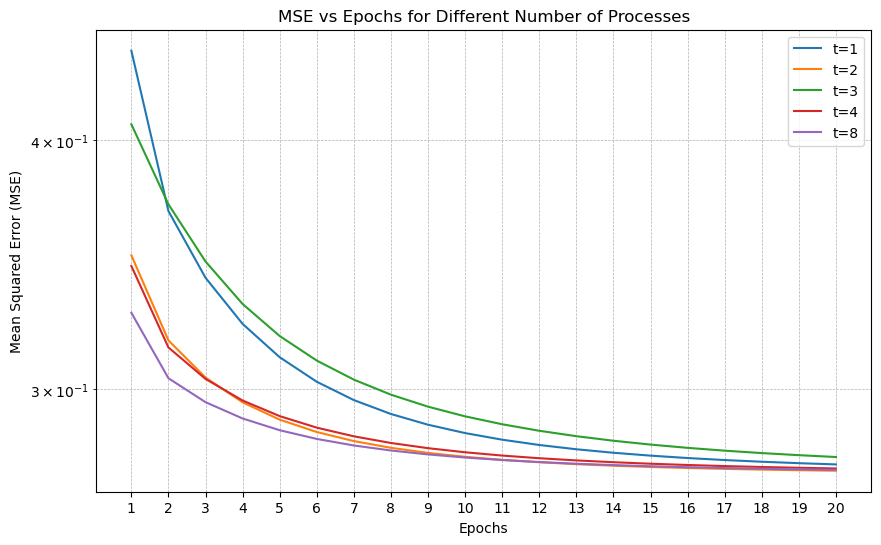

In [49]:
plot_mse_vs_epochs(X, y, 4, 0.0001, 200000)

##### Conclusion
The results highlight that a higher base learning rate combined with a dynamic adjustment accelerates convergence significantly but may risk instability if not controlled. On the other hand, a lower base learning rate with dynamic learning provides smoother convergence but requires more epochs to achieve similar progress. Parallelization consistently improved the speed of convergence, particularly in the early stages, though its efficiency plateaued for larger numbers of processors.
Overall, this study emphasizes that a strategic combination of dynamic learning rates and parallel processing can significantly enhance the efficiency and effectiveness of the SGD algorithm. These optimizations are particularly valuable when working with large datasets, where computational efficiency and stability are critical to achieving high-quality results. Future work could explore adaptive strategies for determining the optimal base learning rate and scaling parallelization for even larger datasets.
